## FEM Rectangle Example

Example of Finite Element Method on plain stress state.

Solves an elasticity problem for a rectangular domain
using a regular mesh of triangular linear elements.

The boundary conditions are dirichlet homogeneous and Newmann.

### License

```
% working on GNU Octave v. 3.6.4
% @ Copyleft, all wrongs reserved
%
% Date      Description                           Author
% Sep-2009  Creation                              J.M. Perez Zerpa
% Sep-2013  test on octave 3.6.4, comments added. J.M. Perez Zerpa
% Sep-2014  Inclusion vtk output functions        J.   Perlas
% ---------------------------------------------------------------------
```

## Parameters

### Material properties

In [1]:
E   = 200e6 # Young modulus
nu  = 0.25  # Poisson modulus

0.25

### Mesh properties

In [2]:
L   = [1.0, 4.0]         # dimension in each direction
t   = 0.2;               # thickness

nx  = 10                 # number of divisions in direction x
ny  = 20                 # number of divisions in direction y
nel = [nx, ny]

neltot = 2 * nx * ny;    # total number of elements

### Mesh construction

In [3]:
nnos         = nel .+ 1       # number of nodes in each direction
nnosx, nnosy = nnos

nnostot      = nnosx * nnosy  # total number of nodes

231

### Boundary Conditions

In [4]:
q   = 1e6  # distributed load on the up_edge

startloadnode = (nnosy - 1) * nnosx + 1
endinloadnode = nnosx * nnosy

LoadNodes = startloadnode:endinloadnode

# nodes cordinates matrix
lins1   = range(0, L[1], length=nnosx)
lins2   = range(0, L[2], length=nnosy);

## Preprocessing


### Constitutive Matrix

In [5]:
# matrix for plain strees state
C = E / (1-nu^2) * [ 1   nu  0           ;
                     nu  1   0           ;
                     0   0   (1-nu)/2    ]

# nodes first column x-coord  second column y-coord
nodes = zeros(nnostot, 2)

for i = 1:nnosy   # discretiza primero por y
    idx = (nnosx * (i-1) + 1) : (nnosx*i)
    nodes[idx, 1] .= lins1
    nodes[idx, 2] .= fill(lins2[i], nnosx)
end

### Connectivity matrix

In [6]:
Mcon = Matrix{Int64}(undef, neltot, 3); # connectivity matrix
for j = 1:ny
    for i = 1:nx
        intri1 = 2*(i-1)+1+2*(j-1)*nx
        intri2 = intri1 + 1
        Mcon[intri1, :] .= [j*nnosx+i,   (j-1)*nnosx+i,  j*nnosx+i+1     ]
        Mcon[intri2, :] .= [j*nnosx+i+1,  (j-1)*nnosx+i,  (j-1)*nnosx+i+1] 
    end
end

### Degrees of freedom (fixed and free)

In [7]:
function nodes2dofs(u)
    v = Vector{Int64}(undef, 2*length(u))
    for i in 1:length(u)
        v[2i-1] = 2u[i] - 1
        v[2i] = 2u[i]
    end
    return v
end

nodes2dofs (generic function with 1 method)

In [8]:
FixNodes = 1:nnosx
FixDofs = nodes2dofs(FixNodes)              # first add all dofs of the nodes
deleteat!(FixDofs, 3:2:(length(FixDofs)-2)) # then remove the free dofs of the nodes

LibDofs = Vector(1:2*nnostot)               # free degrees of fredom
deleteat!(LibDofs, FixDofs);

### Build Elements coordinate vectors

In [9]:
Xel = Matrix{Float64}(undef, 3, neltot)
Yel = Matrix{Float64}(undef, 3, neltot);

for i = 1:neltot
    Xel[:, i] .= nodes[Mcon[i, :], 1] # the j-th column has the x value at the j-th element 
    Yel[:, i] .= nodes[Mcon[i, :], 2] # the j-th column has the y value at the j-th element
end

## Processing

### Stiffness Matrix

In [10]:
using SparseArrays, LinearAlgebra

In [11]:
# calculates element matrices for clockwise numeration
function stiffness_matrix(x, y, C, t)

    A = det([ones(1, 3); x'; y']) / 2 # element area
    
    B = 1 / (2*A) * [ y[2]-y[3]                0    y[3]-y[1]            0    y[1]-y[2]           0   ;
                             0          x[3]-x[2]           0     x[1]-x[3]           0     x[2]-x[1] ;
                     x[3]-x[2]          y[2]-y[3]    x[1]-x[3]    y[3]-y[1]   x[2]-x[1]     y[1]-y[2] ]

    K = B' * C * B * A * t
    return K
end

stiffness_matrix (generic function with 1 method)

In [12]:
KG = spzeros(2*nnostot, 2*nnostot);
for i = 1:neltot
    Ke = stiffness_matrix(Xel[:, i], Yel[:, i], C, t)
    aux = nodes2dofs(Mcon[i, :])
    KG[aux, aux] .+= Ke
end

### Independent Term

In [13]:
areaelemsup = L[1] / nx * t

f = zeros(2*nnostot);

f[2*LoadNodes[1]] = 0.5 * areaelemsup;

for i in 2:(length(LoadNodes)-1)
    idx = 2 * LoadNodes[i]

    # fuerza horizontal
    f[idx-1] = 1 * areaelemsup
end
f[2*LoadNodes[end]] = 0.5 * areaelemsup

F = q * f;

### System resolution

In [14]:
using BenchmarkTools

In [15]:
K = sparse(KG[LibDofs, LibDofs]);
FLib = F[LibDofs]

u = K \ FLib;

U = zeros(2*nnostot);
U[LibDofs] .= u;

Ux = U[1:2:2*nnostot-1]
Uy = U[2:2:2*nnostot];

In [16]:
epsilons = Matrix{Float64}(undef, neltot, 3)
sigmas = Matrix{Float64}(undef, neltot, 3);

In [17]:
for i = 1:neltot
    A = det([ones(1, 3); Xel[:, i]'; Yel[:, i]']) / 2 # area of the element

    Xi = Xel[:, i]
    Yi = Yel[:, i]
    B = 1/(2*A)* [Yi[2]-Yi[3]              0    Yi[3]-Yi[1]              0    Yi[1]-Yi[2]              0  ;        
                            0    Xi[3]-Xi[2]              0    Xi[1]-Xi[3]              0    Xi[2]-Xi[1]  ;
                  Xi[3]-Xi[2]    Yi[2]-Yi[3]     Xi[1]-Xi[3]   Yi[3]-Yi[1]    Xi[2]-Xi[1]    Yi[1]-Yi[2]  ]

    # computation of the degrees of freedom of the element 
    glibelem = nodes2dofs(Mcon[i, :])
    eps_i = B * U[glibelem]
    epsilons[i, :] .= eps_i   # compute deformation
    sigmas[i, :] .= C * eps_i # compute new tensions
end

## Plotting

### Undeformed mesh

In [18]:
using Plots

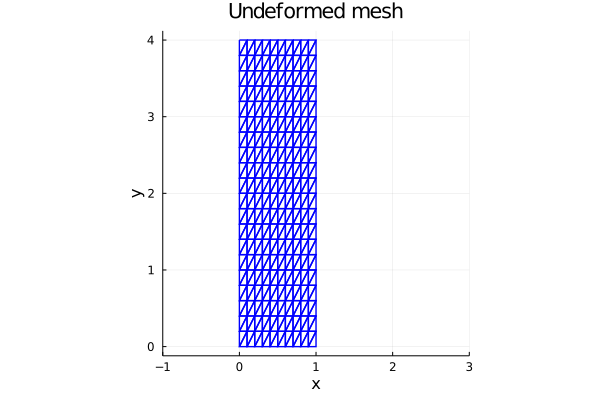

In [19]:
fig = plot(ratio=1, xlimits=(-1, 3), title="Undeformed mesh", xlabel="x", ylabel="y")

plot!(fig, [Xel[:, 1]; Xel[1, 1]], [Yel[:, 1]; Yel[1, 1]], linecolor=:blue, linewidth=1.4, label="")
for i = 2:neltot
    plot!(fig, [Xel[:, i]; Xel[1, i]], [Yel[:, i]; Yel[1, i]], linecolor=:blue, linewidth=1.4, label="")
end
fig

### Deformed mesh

In [20]:
# repeat nodes matrix construction with new displacements
nodesdef = hcat(nodes[:, 1] + Ux, nodes[:, 2] + Uy);

Xeld = copy(Xel)
Yeld = copy(Yel)

# build elements coordinate vectors
for i = 1:neltot
    Xeld[:, i] = nodesdef[Mcon[i, :], 1] #  the j-th column has the x coordinate of the j-th element 
    Yeld[:, i] = nodesdef[Mcon[i, :], 2] #  the j-th column has the y coordinate of the j-th element 
end

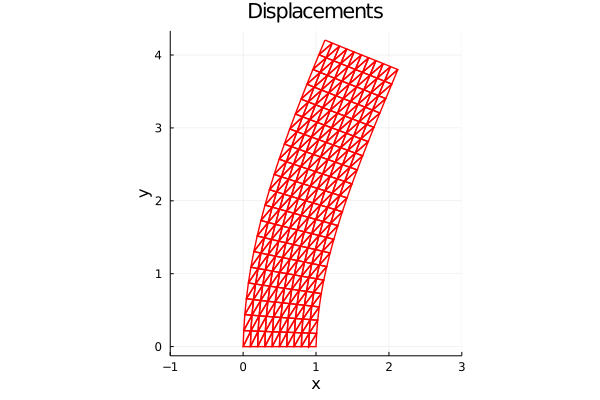

In [21]:
fig = plot(ratio=1, xlimits=(-1, 3), title="Displacements", xlabel="x", ylabel="y")

plot!(fig, [Xeld[:, 1]; Xeld[1, 1]], [Yeld[:, 1]; Yeld[1, 1]], linecolor=:red, linewidth=1.4, label="")
for i = 2:neltot
    plot!(fig, [Xeld[:, i]; Xeld[1, i]], [Yeld[:, i]; Yeld[1, i]], linecolor=:red, linewidth=1.4, label="")
end
fig

## VTK Output (TODO)

TO-DO

```matlab
%===================================================================


disp('ATENCION: cree la carpeta output y si ya existe vaciela por favor!!')
intIteraciones=input('Ingrese el numero de cuadros para la animacion: ->');

for j=0:intIteraciones
	%vtk_2d (j,intIteraciones,"output","MEF_CST",nnostot,nodes,Ux,Uy,neltotal,Mcon',epsilons,sigmas)
	vtk_3d (j,intIteraciones,"output3d","MEF_CST",t,nnostot,nodes,Ux,Uy,neltotal,Mcon',epsilons,sigmas)
end
disp('listo. Abra paraview para ver los vtks')





function vtk_2d (intIteracion,intIteraciones,strOutput,strTitulo,intNodos,arrNodos,arrDespX,arrDespY,intElementos,arrConect,arrDeform,arrTensiones)
	format short
	
	intCifras=ceil(log10(intIteraciones+1));	
	iterationid=int2str(intIteracion);
	for i=1:(intCifras-1)
		if intIteracion/(10^i) < 1
			iterationid = strcat(int2str(0),iterationid);
		endif
	endfor
	
	[err,msg] = mkdir ( "output" );
	strArchivo = ["./output/" strOutput "_" iterationid ".vtk"]
	fid=fopen(strArchivo,'w');

	fdisp(fid,"# vtk DataFile Version 2.0")
	fdisp(fid,strTitulo)
	fdisp(fid,"ASCII")
	fdisp(fid,"DATASET UNSTRUCTURED_GRID")
	fdisp(fid,"")

	fdisp(fid,["POINTS " int2str(intNodos) " float"])
	for i=1:intNodos
		fdisp(fid,["   " mat2str(arrNodos(i,1)+intIteracion/intIteraciones*arrDespX(i),5) "   " mat2str(arrNodos(i,2)+intIteracion/intIteraciones*arrDespY(i),5) "   0"])
	endfor

	arrConect = arrConect .- 1;
	fdisp(fid,"")
	fdisp(fid,["CELLS " int2str(intElementos) " " int2str(4*intElementos)])  
	for i=1:intElementos
		fdisp(fid,["   3   " int2str(arrConect(1,i)) "   " int2str(arrConect(2,i)) "   " int2str(arrConect(3,i))])
	endfor

	fdisp(fid,"")
	fdisp(fid,["CELL_TYPES " int2str(intElementos)])  
	for i=1:intElementos
		fdisp(fid,"   5")
	endfor

	fdisp(fid,"")
	fdisp(fid,["POINT_DATA " int2str(intNodos)])
	fdisp(fid,"VECTORS desplazamientos float")
	for i=1:intNodos
		fdisp(fid,["   " mat2str(intIteracion/intIteraciones*arrDespX(i),5) "   " mat2str(intIteracion/intIteraciones*arrDespY(i),5) "   0"])
	endfor

	fdisp(fid,"")
	fdisp(fid,["CELL_DATA " int2str(intElementos)])
	fdisp(fid,"VECTORS deformaciones float")
	for i=1:intElementos
		fdisp(fid,["   " mat2str(intIteracion/intIteraciones*arrDeform(i,1),5) "   " mat2str(intIteracion/intIteraciones*arrDeform(i,2),5) "   " mat2str(intIteracion/intIteraciones*arrDeform(i,3),5)])
	endfor

	fdisp(fid,"")
	fdisp(fid,"VECTORS sigmas float")
	for i=1:intElementos
		fdisp(fid,["   " mat2str(intIteracion/intIteraciones*arrTensiones(i,1),5) "   " mat2str(intIteracion/intIteraciones*arrTensiones(i,2),5) "   " mat2str(intIteracion/intIteraciones*arrTensiones(i,3),5)])
	endfor
	fclose(fid);



function vtk_3d (intIteracion,intIteraciones,strOutput,strTitulo,espesor,intNodos,arrNodos,arrDespX,arrDespY,intElementos,arrConect,arrDeform,arrTensiones)
	format short
	
	intCifras=ceil(log10(intIteraciones+1));
	iterationid=int2str(intIteracion);
	for i=1:(intCifras-1)
		if intIteracion/(10^i) < 1
			iterationid = strcat(int2str(0),iterationid);
		endif
	endfor
	
	[err,msg] = mkdir ( "output" );
	strArchivo = ["./output/" strOutput "_" iterationid ".vtk"] ;
	fid=fopen(strArchivo,'w');

	fdisp(fid,"# vtk DataFile Version 2.0")
	fdisp(fid,strTitulo)
	fdisp(fid,"ASCII")
	fdisp(fid,"DATASET UNSTRUCTURED_GRID")
	fdisp(fid,"")

	fdisp(fid,["POINTS " int2str(2*intNodos) " float"])
	for i=1:intNodos
		fdisp(fid,["   " mat2str(arrNodos(i,1)+intIteracion/intIteraciones*arrDespX(i),5) "   " mat2str(arrNodos(i,2)+intIteracion/intIteraciones*arrDespY(i),5) "   0"])
	endfor
	for i=1:intNodos
		fdisp(fid,["   " mat2str(arrNodos(i,1)+intIteracion/intIteraciones*arrDespX(i),5) "   " mat2str(arrNodos(i,2)+intIteracion/intIteraciones*arrDespY(i),5) "   " mat2str(espesor)])
	endfor
	
	arrConect = arrConect .- 1;
	fdisp(fid,"")
	fdisp(fid,["CELLS " int2str(intElementos) " " int2str(7*intElementos)])  
	for i=1:intElementos
		fdisp(fid,["   6   " int2str(arrConect(1,i)) "   " int2str(arrConect(2,i)) "   " int2str(arrConect(3,i)) "   " int2str(intNodos+arrConect(1,i)) "   " int2str(intNodos+arrConect(2,i)) "   " int2str(intNodos+arrConect(3,i))])
	endfor

	fdisp(fid,"")
	fdisp(fid,["CELL_TYPES " int2str(intElementos)])  
	for i=1:intElementos
		fdisp(fid,"   13")
	endfor

	fdisp(fid,"")
	fdisp(fid,["POINT_DATA " int2str(2*intNodos)])
	fdisp(fid,"VECTORS desplazamientos float")
	for i=1:intNodos
		fdisp(fid,["   " mat2str(intIteracion/intIteraciones*arrDespX(i),5) "   " mat2str(intIteracion/intIteraciones*arrDespY(i),5) "   0"])
	endfor
	for i=1:intNodos
		fdisp(fid,["   " mat2str(intIteracion/intIteraciones*arrDespX(i),5) "   " mat2str(intIteracion/intIteraciones*arrDespY(i),5) "   0"])
	endfor

	fdisp(fid,"")
	fdisp(fid,["CELL_DATA " int2str(intElementos)])
	fdisp(fid,"VECTORS deformaciones float")
	for i=1:intElementos
		fdisp(fid,["   " mat2str(intIteracion/intIteraciones*arrDeform(i,1),5) "   " mat2str(intIteracion/intIteraciones*arrDeform(i,2),5) "   " mat2str(intIteracion/intIteraciones*arrDeform(i,3),5)])
	endfor

	fdisp(fid,"")
	fdisp(fid,"VECTORS sigmas float")
	for i=1:intElementos
		fdisp(fid,["   " mat2str(intIteracion/intIteraciones*arrTensiones(i,1),5) "   " mat2str(intIteracion/intIteraciones*arrTensiones(i,2),5) "   " mat2str(intIteracion/intIteraciones*arrTensiones(i,3),5)])
	endfor
	fclose(fid);
```